# An introduction to transmission spectroscopy with SPIRou


The goal of this tutorial is to provide to the user simple ingredients to carry out transmission spectroscopy with SPIRou. Based on a publicly available standard sequence of 100 exposures of the M1 dwarf Gl514 (ID: 19AE99, PI: Claire Moutou) obtained with SPIRou on 2019/05/14, this notebook tackles one by one all the steps needed to carry out the search for an hypothetical planet signature within the sequence. This tutorial is a very preliminary approach of the data reduction process and the search for the planet signature in high-resolution sequence of transmission spectra. All comments and suggestions are welcome and any feedback will be greatly appreciated (please contact me at baptiste.klein@irap.omp.eu).

This notebook is organised in 3 main sessions organized as follows:

0. Read the data sets
> This tutorial is associated with a set of 60 exposures (stored in Data/ directory, 60/100 exposures selected for time purpose) downloaded from the Canadian Astronomy Data Centre (CADC, http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/). We select the data reduced by the SPIRou data reduction software (DRS), without correction for tellurics (*e.fits files, cf http://www.cfht.hawaii.edu/Instruments/SPIRou/SPIRou_pipeline.php for the various type of data). For each exposure, we read the AB combined wavelength, flux and blaze function within each order, divide the flux by the Blaze function. From the header of the fits, we read the date (BJD), airmass, barycentric Earth radial velocity (berv) and Signal to Noise Ratio (SNR). Finally, the stellar radial velocity measured from the DRS is read in the associated 'v.fits' file (Drift corrected value, key: CCFRVC). All these information are stored in the '.dat' files located in the 'Data/.' repository. In this tutorial, we work only with the  ***diffraction order 47** (1608-1658 nm) as it hosts strong H2O absorption lines without being drowned into telluric absorption bands.<br>


1. Data reduction process (removal of stellar and telluric spectra and normalisation)
> 1.1 - Removal of the median spectrum and normalisation of each spectrum <br>
> 1.2 - Removal of the residuals of tellurics (detrending with airmass) <br>
> 1.3 - Rejection of outliers and bad pixels <br>
> 1.4 - Removal of the remaing correlated noise using principal component analysis (PCA)

2. Synthesis of a template planet spectrum
> Using a dedicated method described in Section 2, we generated a few very simple models of water absorption spectra for the planet (for time purpose). The goal of this part is to create a model a water absorption signature for the planet given an input transit-curve.

3. Retrieve the planet signature
> Add a realistic planet signature to the reduced sequence of spectra, as a first step <br>
> The goal of this section is to combine all the water absorption lines resolved at SPIRou resolving power to unveil the planet signature within the data. A simplified post-analysis process is proposed  in this tutorial while references are provided to the user if he wants to go further.




## 0 - Read the data

As described in the introduction above, 60 exposures reduced by the SPIRou DRS were selected from the publicly available spectroscopic sequence of Gl514 (2019 May 14). The Blaze-corrected exposures are available in the directory **Data/** and stored in the format <br>
date[BJD] \n berv[km/s] \n rv_s[km/s] \n snr[DRS] \n airmass \n  Wavelength[nm] Itensity[Blaze-corrected]

In this preliminary Section, we create an Object 'Observations', implemented in **'data_red.py'**, that contain all the methods and attribute to conduct the data reduction (see Section 1).

#### 0.1. Read raw data sets
The exposures in 'Data/' do not contain any planet signatures.

In [2]:
import numpy as np
lambdas = np.zeros((2,80))
Wmean_tot = []

Read data
Read data - no planet
DONE


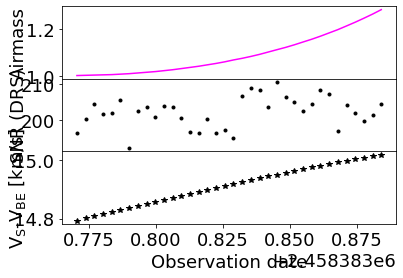

(2291.251754237871, 2363.0317427097107, 2327.141748473791)

In [3]:
from data_red import *

num_ord =33
Wmean_input = 2328.5343131275904
#rep_data    = "/Users/florian/Desktop/Atmosphere_SPIRou/HD189_DRS/Ord_"+str(num_ord)+"/"    ### Repository where data are stored
#rep_data    = "/Users/florian/Desktop/Atmosphere_SPIRou/HD189/Ordres_HD189733/Ord_"+str(num_ord)+"/"    ### Repository where data are stored
rep_data    = "/Users/florian/Desktop/Atmosphere_SPIRou/MCMC_atmo/Sep18/"+str(num_ord)+"/0"
#rep_data    = "/Users/florian/Desktop/Atmosphere_SPIRou/MCMC_atmo/Jun19/1/PCA_1/PCA/"+str(num_ord)+"/0"
rep_data = "/Users/florian/Desktop/Atmosphere_SPIRou/reduction_baptiste/V2/Results/Sep18/PCA/"+str(num_ord)+"/0"
rep_data = "/Users/florian/Downloads/Test_co"
### Read the blaze-corrected exposures
lim_outlier = 2.0    #Limit above which the point is not read
name_obs    = "HD189_Jun19"   #Name of the sequence

### Create object to make data reduction
OBS = Observations(name_obs) 

planet = False  ### if true, store exposures in a dedicated attribute of the class Observations
                ### In the case without planet -> exposures stored in Observation.I_raw

### Read data
OBS.read_data(rep_data,lim_outlier,planet)

### Plot airmass, snr 0.02,0.08and shift to move to the stellar rest frame for all the exposures
OBS.plot_infos()

OBS.W_raw[0],OBS.W_raw[-1],0.5*(OBS.W_raw[0]+OBS.W_raw[-1])
#OBS.date

#### 0.3. Plot sequence of spectra

Use the global function 'plot_2D' to display the sequence of spectra

/Users/florian/Desktop/Atmosphere_SPIRou/HD189/data_red.py:94: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cc   = ax.pcolor(X, Y, Z,**kwargs)


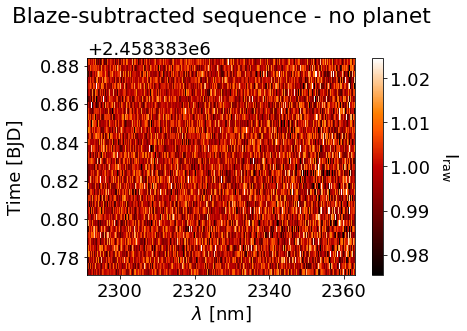

2327.141748473791


In [4]:
### Plot the dynamical spectrum of the order

### Limits of the x and y axes
x_lim = [np.min(OBS.W_raw),np.max(OBS.W_raw)] #Limits of wavelength axis
y_lim = [np.min(OBS.date),np.max(OBS.date)]   #Limits of time axis (or orbital phase)
LIM   = [x_lim,y_lim]

z_inf,z_sup = np.median(OBS.I_raw)-3.*np.std(OBS.I_raw),np.median(OBS.I_raw)+3.*np.std(OBS.I_raw) #Inf and Sup imits of the colormap

### Labels of the map
x_lab = r"$\lambda$ [nm]"     #Wavelength axis
y_lab = r"Time [BJD]"         #Time axis
z_lab = r"I$_{\rm{raw}}$"     #Intensity (exposures)
LAB   = [x_lab,y_lab,z_lab]

### Titles of the plots
title_nopl = "Blaze-subtracted sequence - no planet"              #No planet

### Plot -- same **kwargs as matplotlib fct pcolor
plot_2d(OBS.W_raw,OBS.date,OBS.I_raw,LIM,LAB,title_nopl,vmin=z_inf,vmax=z_sup,cmap="gist_heat")#no planet
# Uncomment for Baptiste's synthetic data

print(0.5*(OBS.W_raw[0] + OBS.W_raw[-1]))


In [5]:
W_filt_nopl_2          = OBS.W_raw
I_filt_nopl_2 = OBS.I_raw
I_pca_nopl = OBS.I_raw
W_corr,V_corr = OBS.shift_rv(W_filt_nopl_2,Wmean_input)
suffix= "_CO.txt"
nameI = "I"+str(num_ord)+suffix
nameW = "V"+str(num_ord)+suffix
np.savetxt(nameI,np.array(I_pca_nopl))
np.savetxt(nameW,np.array(V_corr))
lambdas[:,79-num_ord] = [OBS.W_raw[0], OBS.W_raw[-1]]
Wmean_tot.append(Wmean_input)

2328.5343131275904
[-2.34166839 -2.34357022 -2.3454411  -2.34730892 -2.34921362 -2.3510837
 -2.35295581 -2.35482797 -2.35673685 -2.35864666 -2.36052401 -2.36238947
 -2.36429972 -2.36617402 -2.36804642 -2.36991425 -2.37178399 -2.37368878
 -2.37555868 -2.37742758 -2.37928929 -2.38119468 -2.38305327 -2.38491698
 -2.38680376 -2.38866    -2.39051781 -2.39239868 -2.39424809 -2.39609269
 -2.39793941 -2.39980863 -2.40164561 -2.40347637 -2.40534094 -2.4071653 ] [-17.13518655 -17.14433404 -17.1533185  -17.16227157 -17.17138162
 -17.18030396 -17.18921137 -17.19809192 -17.20711595 -17.21611064
 -17.224917   -17.23363015 -17.24251115 -17.25118176 -17.25979816
 -17.26834585 -17.2768519  -17.28546297 -17.29386034 -17.30219513
 -17.31043766 -17.31880861 -17.32690815 -17.3349621  -17.34304385
 -17.35092168 -17.35873094 -17.36655786 -17.37417345 -17.38168731
 -17.38912527 -17.39656507 -17.40378689 -17.41089337 -17.41803507
 -17.42492644]


In [6]:
prout = np.zeros((80,2))
for i in range(80):
    prout[i] = lambdas[:,79-i]
prout

array([[   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,    0.        ],
       [   0.        ,   

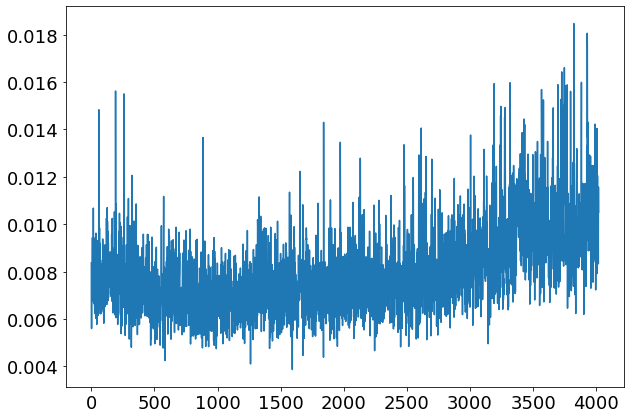

In [8]:

lol = np.zeros(np.shape(I_pca_nopl)[1])
for i in range(np.shape(I_pca_nopl)[1]):
    lol[i] = (np.std(I_pca_nopl[:,i]))
plt.plot(lol)
nameStd = "Std"+str(num_ord)+suffix
np.savetxt(nameStd,lol)

## 1 - Data reduction


#### 1.1. Subtract median spectrum

The first step consists in removing the median spectrum along the time axis. This will remove most of the stellar spectrum and a significant part of the tellurics. Note that this is done on the geocentric frame as the tellurics will be aligned. The stellar spectrum moves by ~500 m/s and will leave residuals that will be corrected in further steps of the data reduction process (another method is to model the stellar spectrum and to shift it in the geocentric frame). 

**Use the method Observations.subtract_median() to compute the median spectrum along the time axis and then divide each exposure by the median spectrum.**

**Note:** We propose to compute the median spectrum on all the available exposures (including during transit) as (i) a larger number of used exposures considerably lower the noise in the median spectrum and (ii) the planet spectrum is expected to be poorly impacted by this computation as it is shifted by ~20 km/s during the sequence. However, it is still possible to compute the median on the out-of-transit spectra only by adding to the method Observations.subtract_median 2 arguments: ind_ini and ind_out, which stand respectively for the indices of the beginning and end of the transit event (here ind_ini = 15, ind_end = 46).

In [ ]:
### Compute median stellar spectrum, I_med, and divide each exposure by I_med
I_med_nopl, I_sub_nopl = OBS.subtract_median(OBS.I_raw)     ### On data set without planet

### Uncomment the following 3 lines to compute median on out-of-transit spectra only
#ind_ini,ind_end        = 14,46
#I_med_nopl, I_sub_nopl = OBS.subtract_median(OBS.I_raw,ind_ini,ind_end)     ### On data set without planet

In [ ]:
### Uncomment the following lines to plot median spectrum

plt.plot(OBS.W_raw,I_med_nopl,"--")
plt.xlabel(r"$\lambda$ [nm]")
plt.ylabel(r"I$_{\rm{med}}$")
plt.show()

#### 1.2. Normalize residual spectra

It is crucial to normalize the median-subracted spectra without adding unwanted features that could mask the planet signature and create false positives. We propose 2 methods to normalize the spectra: (i) make an iterative low-order polynomial fit with outlier removal at each iteration to each residual exposure, then divide the corresponding exposure by the best model; (ii) for each exposure, compute a 'continuum' spectra by applying a moving median to each residual exposure, then divide each exposure by the continuum spectrum. Method (ii) is more adaptable and can be seen as a low-pass filter, where the length of the window to compute the moving median controls the range of frequencies (in wavelength space) including in the continuum spectrum. This option is useful to some diffraction orders exhibiting significant low frequencies structures.

We recommand the user to use the moving median solution for the order considered here (47). The user has to option to plot one by one all the normalized spectra (with the best fit to the continuum), but it may take a bit of time. If the user has some time left, they is invited to try the normalization with polynomial fit.

**Note:** For case (ii), the size of the moving window is determined by 'N_best' (half of the nb of pts used to compute the median). To tune this parameter, we make N_best varies and compute the standard deviation of the resulting normalized spectrum. We then select the largest value such that the standard deviation of the normalized spectra is roughly flat. The parameter N_bor is the number of points removed at each edge of each exposure to avoid edge effects. If N_best > N_bor, the moving average is computing on smaller amount of points until N_best pts are available on both sides.

In [ ]:
plot_nopl = True   ### Uncomment to display all the normalized exposures

N_best = 200   ### N_best: half width of the moving window (in term of nb of pts - see note above)
N_bor  = 50    ### N_bor:  number of points removed at each edge of each exposure (see note above)

### Normalize each spectrum using a moving median (case (ii))
### Generally takes a bit time - but not enough to drink a coffee (I think)
#I_norm_nopl, W2 = OBS.norm_mav(OBS.W_raw,I_sub_nopl,N_best,N_bor,plot_nopl) #no planet injected


### Uncomment the following lines to normalize using low-order polynomial fit
sig_clip    = 5.0 #sig_clip: pts deviating from more than 'sig_clip' sigmas to the model are removed
I_norm_nopl = OBS.norm_pol(OBS.W_raw,I_sub_nopl,plot=True)  #no planet
W2          = OBS.W_raw

In [ ]:
### Uncomment the following lines to planet the sequence of normalized spectra on a 2D map

### Limits of the axes
x_lim = [np.min(W2),np.max(W2)]
y_lim = [np.min(OBS.date),np.max(OBS.date)]
LIM   = [x_lim,y_lim]

z_inf,z_sup = 0.9,1.1  ### color bar

### Labels on the axes (z = colorbar)
x_lab = r"$\lambda$ [nm]"
y_lab = r"Time [BJD]"
z_lab = r"I$_{\rm{raw}}$"
LAB   = [x_lab,y_lab,z_lab]

###### Without planet
title_nopl = "Median-subtracted normalized sequence - no planet"
plot_2d(W2,OBS.date,I_norm_nopl,LIM,LAB,title_nopl,vmin=z_inf,vmax=z_sup,cmap="gist_heat")
np.mean(I_norm_nopl,axis=1)

#### 1.3. Detrending with airmass

Clear time-dependent residuals are visible in the sequence on normalized spectra, due to residual tellurics non corrected at step 1.1. It is quite common in the litterature to detrend the sequence of normalized spectra with the airmass (e.g. Brogi et al. 2016, APJ 817, 106B). The method Observations.detrend_airmass() models the airmass-dependent component, namely $I_{\rm{c}}$, by $I_{\rm{c}}(t) = I_{0} + I_{1} \times A(t) +  I_{2} \times A(t)^{2}$, where A(t) is the airmass at time t, and $I_{0}$, $I_{1}$ and $I_{2}$ are the constant, linear and quadratic spectra to be removed from the normalized sequence. Observations.detrend_airmass() uses a least-square estimator (LSE) to estimate those airmass dependent contributions and subtract them from the normalized sequence.

**Note:**  Brogi et al. 2018 (A&A, 615A, 16B) recommends to detrend with airmass in log space. We thus let this as an option in the method Observations.detrend_airmass().

In [ ]:
### Detrending with airmass

deg       = 2    # Degree of the model of airmass (must remain low in order not to eliminate planet signature)
log_space = False   # if True, model fitted in log space
plot      = True  # if True, plot the airmass-dependent components removed with the process

I_m_nopl = OBS.detrend_airmass(W2,I_norm_nopl,deg,log_space,plot)  ### No planet injected
#I_m_nopl = I_norm_nopl

In [ ]:
### Uncomment the following lines to planet the sequence of spectra before and after detrending with airmass

### Limits of the axes
x_lim = [np.min(W2),np.max(W2)]
y_lim = [np.min(OBS.date),np.max(OBS.date)]
LIM   = [x_lim,y_lim]

z_inf,z_sup = 0.95,1.05  ### color bar

# Labels on the axes (z = colorbar)
x_lab = r"$\lambda$ [nm]"
y_lab = r"Time [BJD]"
z_lab = r"I$_{\rm{red}}$"
LAB   = [x_lab,y_lab,z_lab]

###### Before detrending with airmass
title_1 = "Sequence of normalized spectra before detrending with airmass"
plot_2d(W2,OBS.date,I_norm_nopl,LIM,LAB,title_1,vmin=z_inf,vmax=z_sup,cmap="gist_heat")

###### After detrending with airmass
title_2= "After detrending with airmass"
plot_2d(W2,OBS.date,I_m_nopl,LIM,LAB,title_2,vmin=z_inf,vmax=z_sup,cmap="gist_heat")


#### 1.4. Remove outliers

As a first step, we compute the standard deviation of each pixel along the time axis (method Observations.pix_std_distrib). The remaining sequence of spectra should be dominated by a noise of the same order of the noise measured by the SPIRou DRS. We expect the edges of the order to be more polluted by noise than the center of the ordre. As a result, we carry out an iterative polynomial fit with outlier removal on the distribution of the standard deviations of the pixels. All the pixels whose standard deviation is rejected through the polynomial fit are removed from the sequence of spectra. 



In [ ]:
### Compute the standard deviation of each pixel along the time axis
### Make 2nd order polynomial fit and remove pixels deviating for more than sig_clip sigma from the fit

deg       = 2     #Degree of the polynomial fit
sig_clip  = 4.0   #Threshold above which outlierrs are removed
n_iter    = 4     #Number of iterations of the polynomial fit
plot_nopl = True  #Plot the distribution of standard dev. and best fit - no planet

W_filt_nopl,I_filt_nopl = OBS.px_std_distrib(W2,I_m_nopl,sig_clip,deg,n_iter,plot_nopl) #no planet

#### 1.5. Re-apply all the steps

Once bad pixels are removed from the sequence of spectra, we propose to apply all the steps above (subtract median, normalization, detrending with airmass and outlier removal), but this time, by normalizing the residual spectra using a polynomial fit rather than a moving median, as the low-frequency structures has already been corrected.


In [ ]:
### Compute and divide each spectrum by the median spectrum
### Enter 'ind_ini,ind_end' as an argument of the fct to compute on out-of-transit spectra
I_med_nopl2, I_sub_nopl2 = OBS.subtract_median(I_filt_nopl)  ### On data set without planet

### Normalize spectra using a polynomial fit
plot_pol_nopl = False
I_norm_nopl_2 = OBS.norm_pol(W_filt_nopl,I_sub_nopl2,plot=False)

### Detrend with airmass
deg        = 2     # Degree of the model of airmass (must remain low in order not to eliminate planet signature)
log_space  = False # if True, model fitted in log space
plot       = False  # if True, plot the airmass-dependent components removed with the process
I_m_nopl_2 = OBS.detrend_airmass(W_filt_nopl,I_norm_nopl_2,deg,log_space,plot)  ### No planet injected
#I_m_nopl_2 = I_norm_nopl_2

### Reject bad pixels
deg       = 2      #Degree of the polynomial fit
sig_clip  = 4.0    #Threshold above which outleirs are removed
n_iter    = 4      #Number of iterations of the polynomial fit
plot_nopl = True  #Plot the distribution of standard dev. and best fit - no planet
W_filt_nopl_2,I_filt_nopl_2 = OBS.px_std_distrib(W_filt_nopl,I_m_nopl_2,sig_clip,deg,n_iter,plot_nopl) #no planet



#### 1.6. Remove correlated residuals with PCA

We assume (and it is the case here) that the variance within the reduced sequence of spectra is dominated by the noise (actually dominated by residuals of tellurics). The reduced sequence of spectra is still dominated by residuals of tellurics. By applying principal component analysis to the sequence of reduced spectra, we can build a new sequence where the components that contribute the most to the variance within the sequence are removed. To select the number of components to suppress the systematics within the sequence of spectra without over-fitting it, we can compute the evolution of the relative weight of each singular value of the PCA. A break in this evolution means that the variance is sensible to different types of structures. This is a first order analysis. You can go further by computing the eigenvalues of realistic noise maps and use them as threshold.

**By applying PCA to the reduced sequence of spectra, find the number of components that lead to a distribution of standard deviations similar to that provided by the DRS**


In [ ]:
N_comp = 1 ### Number of components removed using PCA (remove the N_comp component with the largest eigenvalue)

### I_pca_nopl: Reduced sequence of spectra obtained by removing N_comp components with PCA
### I_del_nopl: list of all components removed with PCA (each component is a 2D array)
### e_val_nopl: Vector of the eigenvalues of the covariance matrix

I_pca_nopl,I_del_nopl,e_val_nopl = make_pca(N_comp,I_filt_nopl_2) # Case no planet


### It can be useful to plot the evolution of the eigenvalues depending on the component in the PCA basis
### Uncomment the line below to see
plt.plot(e_val_nopl,"*",label="black")
plt.ylabel(r"e/($\Sigma$e)")
plt.xlabel("Component")
plt.show()


### Uncomment the two lines below to plot the sequence of spectra cleaned with PCA

x_lim = [np.min(W_filt_nopl_2),np.max(W_filt_nopl_2)]
y_lim = [np.min(OBS.date),np.max(OBS.date)]
LIM   = [x_lim,y_lim]

# Labels on the axes (z = colorbar)
x_lab = r"$\lambda$ [nm]"
y_lab = r"Time [BJD]"
z_lab = r"I$_{\rm{PCA}}$"
LAB   = [x_lab,y_lab,z_lab]


## No planet
#title_nopl = "PCA - " + str(N_comp) + " components removed - no planet"
#plot_2d(W_filt_nopl,OBS.date,I_pca_nopl,LIM,LAB,title_nopl,vmin=-0.05,vmax=0.05,cmap="gist_heat")

### Uncomment to plot each component removed using PCA - no planet
c = 1
for idel in I_del_nopl:
    title = "PCA - Component " + str(c) + " - no planet"
    plot_2d(W_filt_nopl_2,OBS.date,idel,LIM,LAB,title,vmin=-0.03,vmax=0.03,cmap="gist_heat")
    c += 1


### Plot the standard deviation of each spectrum cleaned with PCA
N_mid    = 400 #Half width of the centered window used to compute the SNR (I[id_mid-N_mid:id_mid+N_mid]
sig_clip = 4.0 #Compute the SNR by doing a sig_clip-sigma clipping
OBS.spec_std_distrib(W_filt_nopl_2,I_pca_nopl,N_mid,sig_clip)




title = "Compar with SNR"

plot_2d(W_filt_nopl_2,OBS.date,I_pca_nopl,LIM,LAB,title,vmin=-0.03,vmax=0.03,cmap="gist_heat")




#### 1.7. Move the sequence of spectra into the stellar rest frame

Move the sequence of spectra into the stellar rest frame by shifting the wavelength vector of each exposure by $\Delta V(t) = V_{\rm{S}}(t) - V_{\rm{BE}}(t)$, where $V_{\rm{BE}}(t)$ is the BERV at time t and $V_{\rm{S}}(t)$ the stellar radial velocity at time t. **WARNING:** the resulting wavelengths are now 2D arrays of the size of I_pca_nopl.


In [ ]:
W_corr,V_corr = OBS.shift_rv(W_filt_nopl_2)

In [ ]:
OBS.dates

In [ ]:
suffix= "_old_PCA1.txt"
nameI = "Ipca"+str(num_ord)+suffix
nameW = "Vcorr"+str(num_ord)+suffix
np.savetxt(nameI,np.array(I_pca_nopl))
np.savetxt(nameW,np.array(V_corr))
lambdas[:,num_ord] = [OBS.W_raw[0], OBS.W_raw[-1]]

In [ ]:
nameL = "lambdas"+suffix
np.savetxt(nameL,lambdas)
lambdas.T

## 2 - Create model


#### 2.1. Read the templates

For this tutorial, we generated 3 templates of planetary transmission spectrum containing only water absorption lines and collision-induced absorptions for H2-H2 and He-H2. The templates were generated using a 1D isothermal homogeneous atmosphere for the synthetic planet, we use use the petitRADTRANS python module (Molliere et al. 2019, A&A, 627A, 67M), that carries out a line-by-line resolution of the radiative transfer equation for all water absorption lines in HITEMP2010 database (Rothman et al. 2010, J. Quant. Spec. Radiat. Transf., 111, 2139) at the equilibrium temparature of the planet. The 3 templates were generated assuming respectively an equilibrium temperature of 800, 1100 and 1400K for **template_T800.dat**, **template_T1100.dat**, and **template_T1400.dat**. The first step is thus to read and plot the templates using the script below.


We propose to generate a synthetic planet signature using the method described below and, by using the orbital properties of the planet, shift this signature with time. The planet properties, inspired from HD189733b (except for the inclination of thhe planet orbit), are described in the Table below, where we assumed a circular orbit for the planet. Assuming  Please note that many useful tools for exoplanet modelling can be found in this NASA website: https://emac.gsfc.nasa.gov/. Using the the simple equation $V_{\rm{r}}(t) = K_{\rm{p}} \sin \left( \frac{2\pi}{P_{\rm{orb}}} (t - T_{0}) \right) + V_{0}$, where $V_{0} = 0$ km/s, we shift the resulting transmission spectrum in the planet rest frame. Finally, we multiply the resulting synthetic sequence by an inversed transit window (maximum signal at mid-transit), obtained using the batman python module (https://www.cfa.harvard.edu/~lkreidberg/batman/) assuming a non-linear limb-darkening model with coefficients from Hayek et al. 2012 (A&A, 539A, 102H).




| Planet properties                      | Value             |
|----------------------------------------|-------------------|
|Radius (R$_{\rm{p}}$)                   |0.157 R$_{\rm[S}$  |
|Mass (M$_{\rm{p}}$)                     |1.142 M$_{\rm{J}}$ |
|Transit inclination ($i$)               |90.0 deg           |
|Orbital period (P$_{\rm{orb}}$)         |2.218 d            |
|semi-major-axis ($a$)                   |8.863 R$_{\rm[S}$  |
|Mid-transit time (T$_{0}$)              |2458617.87046 [BJD]|
|Semi-amplitude (K$_{\rm{p}}$)           |154.5 km/s         |
|Equilibrium temperature (T$_{\rm{eq}}$) |1100 K             |
|Composition atmosphere                  |H2, He, H20        |
|Volume mixing ratio (VMR, H2O)          |10^(-3)            |




In [7]:
from model import *

rep_mod = "Models" ### Directory where the model templates are stores

### Create model object
MOD = Model()

### Read all the templates included in the rep_mod directory
MOD.read_models(rep_mod)


Read models
mod_babak
DONE


In [8]:
0.5*(OBS.W_raw[0] + OBS.W_raw[-1]) 

2327.141748473791

#### 2.2. Create weighting window

Using one of the templates described above, we model the sequence of spectra by creating a sequence of template spectra for the planet atmosphere weighted by a window built from the transit light-curve (the weight is 1 at mid-transit and 0 when the planet is not transiting. In the code below, we use the BATMAN python module (https://www.cfa.harvard.edu/~lkreidberg/batman/) to generate the weighting window with the planet parameters described in Section 0.2.

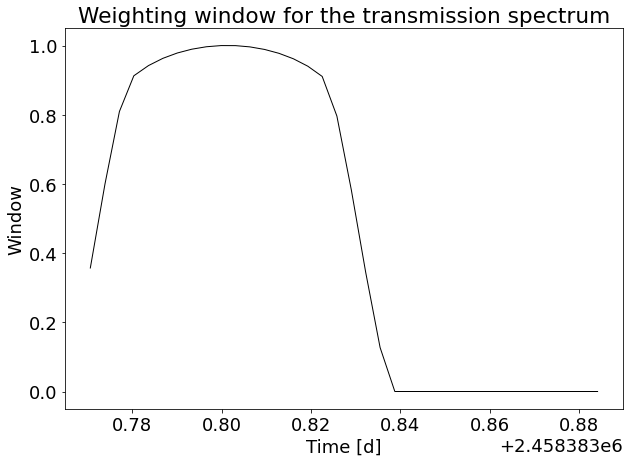

[0.35701705 0.6001163  0.80948416 0.91267935 0.94219889 0.96314465
 0.97855704 0.98948546 0.9966081  1.         0.99983387 0.99622575
 0.98882063 0.97757311 0.96179295 0.94040111 0.9107689  0.79627471
 0.58315494 0.34403953 0.12705116 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]


array([2458383.77055943, 2458383.77384704, 2458383.77707875,
       2458383.78030307, 2458383.78358918, 2458383.78681399,
       2458383.79004101, 2458383.79326712, 2458383.79655574,
       2458383.79984545, 2458383.80307906, 2458383.80629228,
       2458383.80958299, 2458383.8128124 , 2458383.81603942,
       2458383.81925973, 2458383.82248474, 2458383.82577195,
       2458383.82900097, 2458383.83223048, 2458383.8354501 ,
       2458383.83874811, 2458383.84196822, 2458383.84520053,
       2458383.84847654, 2458383.85170346, 2458383.85493727,
       2458383.85821578, 2458383.86144419, 2458383.86466921,
       2458383.86790322, 2458383.87118233, 2458383.87441074,
       2458383.87763435, 2458383.88092406, 2458383.88414957])

In [11]:
import batman

### Generate planet transit and build weighting window for the template

p_nam     = "planet_b"                             # Planet name
rp        = 0.141                                # Planet radius in stellar radius unit [R_s]
inc       = 85.71                                # Inclination of the planet orbit [deg]
t0        = 2454037.612           # Mid-transit time [phase]
a         = 8.839304998                                 # SMA [R_s]
per       = 2.21857545                                   # Orbital period [phase]
ecc       = 0.                                     #eccentricity
w         = -24.1                                    #longitude of periastron (in degrees)
limb_dark = "linear"                            #limb darkening model 
u         = [0.35]      #Hayek+2012
plot      = True                                   #Plot weighting window




### Enter the planet parameters
P = Planet(p_nam)
P.rp        = rp
P.inc       = inc
P.t0        = t0
P.a         = a
P.per       = per
P.w         = w
P.ecc       = ecc
P.ld        = limb_dark
P.u         = u
P.date      = OBS.date




### Generate the transit event
P.make_batman()

### Build weighting window to transform the template of 2D sequence
P.make_window(plot)
print(P.window)



file = open("transit_window.dat","w")
for pp in range(len(P.window)):
    tx = str(OBS.date[pp]) + "  " + str(P.window[pp]) + "\n"
    file.write(tx)
file.close()

OBS.date

#### 2.3. Make model

The user can select the model template used and it will be displayed using the plot_template method of the class Model. We then create model sequence of template spectra weighted by the window defined above and linearly interpolate each spectrum of the sequence so it can be shifted in the velocity space.

In [ ]:
### Build model
template_name =  "mod_babak"  #"template_H20_9" #'template_T1100' ### Key of the template to cross-correlate to the data
                                 ### Use template_T800 or template_T1400 for T_eq = 800 K or T_eq = 1400 K

# ### Plot the template transmission spectrum for the planet (assuming only H2O absorption + H2-H2, H2-He collision induced absorptions)
MOD.plot_template(template_name)

### Build time-dependant sequence of spectra by weighting template by the transit window
FM = MOD.build_model(template_name,P.window)

## 3. Retrieve the planet signature

The planet signature is not visible by eye on the reduced sequence of spectra, which is expected as the deepest individual lines from the planet atmosphere have a depth of ~10^(-3), i.e. 4 times lower than the noise within the sequence. Hence the need to combine as much absorption lines as possible to unveil the planet signature. Each spectrum of our sequence of spectra can be shifted at a given velocity, depending on a set of orbital parameters assumed for the planet. In the stellar rest frame, the radial velocity of the planet is such that $V_{\rm{r}}(t) = K_{\rm{P}} \sin ( 2 \pi \phi ) + V_{0}$, where $V_{0}$ is expected lie close to 0 and $K_{\rm{P}}$ is the semi-amplitude of the planet orbit. The typical signature in transmission left by a close-in transiting planet can be approximated by a straight line whose slope (i.e. the change in RV between the beginning and the end of transit) is controled by $K_{\rm{P}}$ (e.g. Snellen et al. 2010, Nature, 465, 10495, among many other references).

#### 3.1. Explore the orbital parameters of the planet to detect water in its atmosphere

To unveil the planet signature, we propose to explore a grid ($K_{\rm{P}},V_{0}$) and, for each combination of parameters, shift the spectra of the modelled sequence to match the corresponding RV signature. We then compute the correlation coefficient between the shifted model and the reduced data. 

In [ ]:
from ccf import *  ### All the fct relative to search for planet signatures are stored in this file
from scipy import stats
### Initialize the CCF object
CCF        = CCF()
CCF.planet = P      ### Planet object previously defined
CCF.model  = MOD    ### Model object previously defined
CCF.data   = OBS    ### Observations object previously defined

**Note on the algorithm:** For each value of the ($K_{\rm{P}},V_{0}$) grid, each spectrum of the model is binned to match the velocity vector within the data. To get each value of the binned model, we integrate over a thin window center on the pixel value and with a half-width of half of a pixel. This allow to avoid unrealistic values due to the linear interpolation of the model. In the following cell, CCF.ddv refers to this integration window.

**Warning:** Please, do not create a too large grid or it will take too much time to compute. In practice, for longer sequences or when combining several orders, it is encouraged to run the exoploration of the parameter space in parallel, even on a computer cluster.

In [ ]:
### Initialize the grid of parameters

# Kp [km/s]
ki = 0.0   ### Init value of Kp [km/s]
kf = 300.0   ### Last value of Kp [km/s]
Nk = 150   ### Number of values of the vector

# V0 [km/s]
vi = -40.0  ### Init value for V0 [km/s]
vf = 40.0 ### Last value for V0 [km/s]
Nv = 80     ### Number of values of the vector 

# Define integration window (no need to modify this, see note above)
sig_v_int = 1.0   ### Half-width of the window [km/s] (we take half of SPIRou pixel)
N_v_int   = 7     ### Number of points of the integration

### Create instances of the attributes of the CCF object
CCF.K_vec  = np.linspace(ki,kf,Nk)
CCF.V0_vec = np.linspace(vi,vf,Nv)
CCF.ddv    = np.linspace(-sig_v_int,sig_v_int,N_v_int)

#### 3.2. Generate sequence with planet signature

We added the planet signature to the reduced exposures (i.e. those in Data/ directory) and store the resulting spectra in the directory 'Planet/'. When read using the Observations.read_data method, indicate planet = True and the exposures with the planet signatures will be stores in the attribute Observations.I_raw_pl. In what follows, we the index '_pl' denotes the data set where a planet signature is injected, while the index '_nopl' stands for the raw sequence, without planet.


In [ ]:
### Build sequence with a planet

### Orbital parameters of the planet orbit
# Kp = 154.5 #km/s
# V0 = 0.0   #km/s

# ## Synthetic sequence of planet 
# I_pl  = CCF.bin_model(Kp,V0,V_corr)

# x_lim = 1610,1640
# [np.min(W_corr),np.max(W_corr)]
# y_lim = [np.min(OBS.date),np.max(OBS.date)]
# LIM   = [x_lim,y_lim]
# z_inf_pl,z_sup_pl = -0.0004,0.0004
# x_lab = r"$\lambda$ [nm]"
# y_lab = r"Time"
# z_lab = r"I$_{\rm{syn}}$"
# LAB   = [x_lab,y_lab,z_lab]

# title_pl = "Synthetic planet signature"
# plot_2d(W_corr,OBS.date,I_pl,LIM,LAB,title_pl,vmin=z_inf_pl,vmax=z_sup_pl,cmap="gist_heat")


# ## Sequence with synthetic planet
# ampl     = 1.0  ### Amplify or reduce planet signature
# I_pca_pl = I_pca_nopl + ampl*I_pl

In [ ]:
phase  = (OBS.date - P.t0)/(P.per) 
phase -= int(phase[0]) + 1

print(phase)
file = open("phase.txt","w")
for tt in phase: file.write(str(tt) + "\n")
file.close()



In [ ]:
### Exploration of the parameter space - takes ~1 min for ~1000 pts in the (Kp,V0) grid
### Note: a WARNING message will be printed. Ignore it as it is internally handled.

### Uncomment the 3 lines below to make the exploration of the parameter space of the sequence without planet
print("Correlation with reduced sequence of spectra without planet","blue")
corr_nopl = CCF.make_corr_map(V_corr,I_pca_nopl)
print("DONE","green")

### Case with planet
#print("Correlation with reduced sequence of spectra with synthetic planet","blue")
#corr_pl   = CCF.make_corr_map(V_corr,I_pca_pl)
#print("DONE","green")

In [ ]:
### Plot the resulting map
x_lim = [np.min(CCF.V0_vec),np.max(CCF.V0_vec)]
y_lim = [np.min(CCF.K_vec),np.max(CCF.K_vec)]
LIM   = [x_lim,y_lim]

#z_inf_pl,z_sup_pl     = -np.max(corr_pl),np.max(corr_pl)


x_lab = r"$V_{\rm{0}}$ [km/s]"
y_lab = r"$K_{\rm{P}}$ [km/s]"
z_lab = r"Correlation"
LAB   = [x_lab,y_lab,z_lab]

#title_pl = "CCF - with planet"
#plot_2d(CCF.V0_vec,CCF.K_vec,corr_pl,LIM,LAB,title_pl,vmin=z_inf_pl,vmax=z_sup_pl,cmap="gist_heat")


### Uncomment the lines below to plot the correlation map with the sequence with no planet inside
### The sequence with no planet gives an estimation of the standard deviation of the correlation
### without planet and can be used as a first guess to estimate the significance of the detection

z_inf_nopl,z_sup_nopl = -np.max(corr_nopl),np.max(corr_nopl)

title_nopl = "CCF - no planet"
plot_2d(CCF.V0_vec,CCF.K_vec,corr_nopl,LIM,LAB,title_nopl,vmin=z_inf_nopl,vmax=z_sup_nopl,cmap="gist_heat")

#tx  = "Standard deviation of the correlation map without planet: " + str(np.std(corr_nopl))
#tx += "\nMaximum correlation with synthetic planet at ~" + str(round(np.max(corr_pl)/np.std(corr_nopl))) + " sigmas."
#print(tx,"green")


#### 3.2. Cross-correlate the template to each spectrum

In order to make the planet signature appears from the sequence of spectra, we can cross-correlate our template of transmission spectrum to each of the reduced spectrum. A quasi-linear signature should emerge from the process, as described in the introduction of Section 3.

In [ ]:
### Visualize the evolution of the planet signature with time by cross-correlating the
### template of the transmission spectrum with each spectrum of the reduced sequence

### Velocities explored during the cross-correlation process
Vi_ccf = -50
Vf_ccf =  50
NV_ccf =  101

CCF.V0_ccf = np.linspace(Vi_ccf,Vf_ccf,NV_ccf)

### Compute the cross-correlation with the reduced sequence with the planet
ccf_map_pl = CCF.make_ccf(V_corr,I_pca_pl,template_name)


In [ ]:
### Display the signature of the planet on a plane (Time,V0)

x_lim = [np.min(CCF.V0_ccf),np.max(CCF.V0_ccf)]
y_lim = [np.min(OBS.date),np.max(OBS.date)]
LIM   = [x_lim,y_lim]


z_inf_pl,z_sup_pl     = np.median(ccf_map_pl)-3.*np.std(ccf_map_pl),np.median(ccf_map_pl)+3.*np.std(ccf_map_pl)


x_lab = r"$V_{\rm{0}}$ [km/s]"
y_lab = r"$K_{\rm{P}}$ [km/s]"
z_lab = r"Cross-correlation"
LAB   = [x_lab,y_lab,z_lab]

title_pl = "CCF - with planet"
plot_2d(CCF.V0_ccf,OBS.date,ccf_map_pl.T,LIM,LAB,title_pl,vmin=z_inf_pl,vmax=z_sup_pl,cmap="gist_heat")




### Uncomment if you computed the CCF with sequence without planet
#z_inf_nopl,z_sup_nopl     = np.median(ccf_map_nopl)-5.*np.std(ccf_map_nopl),np.median(ccf_map_nopl)+5.*np.std(ccf_map_nopl)
#title_nopl = "CCF - no planet"
#plot_2d(CCF.V0_vec,CCF.K_vec,corr_nopl.T,LIM,LAB,title_nopl,vmin=z_inf_nopl,vmax=z_sup_nopl,cmap="gist_heat")




